# Predicting Pet Adoption Speeds

## Table of Contents

- [Splitting Data](#Splitting-Data)
- [Problem Statement](#Problem-Statement)
- [Executive Summary](#Executive-Summary)  
- [Data Cleaning](#Clean-up)
- [Exploritory Data Analysis](#Exploritory-Data-Analysis)
- [Preprocessing](#Preprocessing)
- [Modeling](#Modeling)
- [K-Nearest Neighbors](#K-Nearest-Neighbors)
- [Decision Tree](#Decision-Tree)
- [Bootstrap and Bagging](#Bootstrap-and-Bagging)
- [Random Forest](#Random-Forest)
- [Extra Trees](#Extra-Trees)
- [Neural Network](#Neural-Network)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Pickling](#Pickling)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Data Source

https://www.kaggle.com/c/petfinder-adoption-prediction/data

## Splitting Data
To get our data in the appropriate form, please being with the "Splitting Data" notebook. We will keep them seperate to avoid any risk of mixing out holdout data with our training and test sets.

## Problem Statement

Around the world millions of dogs and cats sit in shelters, waiting for their forever-homes, which many will never find. Over the course of history, our pets become reliant on humans for food, shelter, and companionship. As a result, dogs and cats need humans to adopt them from shelters and bring them into their homes. The demand for shelter animals varies widely based on the characteristics of each animal, as well as the website post for their adoption. 

We will seek to use data from PetFinder (Malaysia) describing each pet, as well as the metadata from their Petfinder posts to predict the speed at which pets get adopted. Specifically, we will make a classifier model that will predict the speed at which the pet is adopted. We will judge our success on the accuracy of our predictions. Additionally, we will set aside a portion of our data as a validation set to confirm our model’s ability to estimate new entries.

By predicting the speed at which pets get adopted, we hope to gain insight into actionable measures we can take to increase the rate and overall number of adoptions. 

## Executive Summary

Our data contain detailed listings on approximately 15,000 cats and dogs that were listed on the PetFinder website in Malaysia, including the speed category of their adoption. From the "Data Source" listed above we used the set labled 'Train' for our analysis. The initial data was read into the "Splitting Data" notebook and divided into a training and test set as well as a holdout set, which was segmented out of the data to be revisited later for validation. 

Once we have our data read-in, we start with clean up and preliminary analysis. From the outset, we see the data is very clean, but has information we do not want to include, like "resucer_id", "state" (in Malaysia) etc. that needed to be dropped. The largest change we made was to exclude listings of more than 3 pets as these were often entire litters of puppies/kittens rather than individual pets or bonded pairs/triples.

With the cleaned and split data in hand, scaled the data (standard scalar) and began our catagorical modeling. 

After categorical modeling we did regression analysis to attempt to estimate the actual time pets are in the shelter (rather than a speed category). These results were not very stong and not instructive. Though the excercize was worthwhile, there is not much predictive ability in the regression models. 

It is important to note that many of the categories that appear numerical are actually categorical, like breed and color. Those features were indluded using one-hot-encoding for modeling. 

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn import metrics as skm
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

from treeinterpreter import treeinterpreter as ti

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, DBSCAN

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

rdst = 815

In [58]:
pets = pd.read_csv('../data/pets.csv')

In [59]:
pets.shape

(11244, 24)

In [60]:
pets.keys()

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

Most keys are self expalinitory, or are in the Data Dictionary in the Readme file. 

In [61]:
pets.columns = map(str.lower, pets.columns)

In [62]:
pets[pets['quantity'] <= 3].shape

(10249, 24)

# Clean-up

#### For the initial analysis, we will not look at information related to the images other than if a picture or video is present. We will remove (for now):    
  
- Description: We can use this later for NLP  
- PetID: Doesn't tell us anyting 
- State: We will explore whether or not this should be included. These are Malaysian states, so the universal applicability is unlikely.   
- The name category is likely to be important, and will be considered when we get to NLP, but will be excluded from the initial analysis.
- Rescuer ID
  
- Quantity: Unfortunately many of the listings are for entire litters of pups and kittens, given the fundamental difference in trying to adopt out entire litters compared to individual pets, we will exclude full litters. However, there are scenarios where animals need to be adopted together. These are called 'bonded pairs' and we will not exclude them.   
    
      
      
#### Other Considerations:
- Some of the categories appear numerical, but are infact categorical, and not ordinal. Those categories are:
- Breed1
- Breed2
- Color1
- Color2
- Color3
- State




In [63]:
pets.isnull().sum()

type               0
name             927
age                0
breed1             0
breed2             0
gender             0
color1             0
color2             0
color3             0
maturitysize       0
furlength          0
vaccinated         0
dewormed           0
sterilized         0
health             0
quantity           0
fee                0
state              0
rescuerid          0
videoamt           0
description        9
petid              0
photoamt           0
adoptionspeed      0
dtype: int64

We know that a null in the 'name' column means the pet has no name. we can replace this with zero

In [64]:
pets.fillna(0, inplace = True)

In [65]:
pets.isnull().sum().sum()

0

In [66]:
pets['quantity'].value_counts()

1     8612
2     1065
3      572
4      413
5      255
6      152
7       59
8       44
9       23
10      15
11       8
20       8
12       5
17       3
15       3
13       2
14       2
16       2
18       1
Name: quantity, dtype: int64

In [67]:
pets.keys()


Index(['type', 'name', 'age', 'breed1', 'breed2', 'gender', 'color1', 'color2',
       'color3', 'maturitysize', 'furlength', 'vaccinated', 'dewormed',
       'sterilized', 'health', 'quantity', 'fee', 'state', 'rescuerid',
       'videoamt', 'description', 'petid', 'photoamt', 'adoptionspeed'],
      dtype='object')

In [68]:
pets.dtypes

type               int64
name              object
age                int64
breed1             int64
breed2             int64
gender             int64
color1             int64
color2             int64
color3             int64
maturitysize       int64
furlength          int64
vaccinated         int64
dewormed           int64
sterilized         int64
health             int64
quantity           int64
fee                int64
state              int64
rescuerid         object
videoamt           int64
description       object
petid             object
photoamt         float64
adoptionspeed      int64
dtype: object

# Exploritory Data Analysis (EDA)

In [69]:
quant = pets['quantity'].value_counts()
quant


1     8612
2     1065
3      572
4      413
5      255
6      152
7       59
8       44
9       23
10      15
11       8
20       8
12       5
17       3
15       3
13       2
14       2
16       2
18       1
Name: quantity, dtype: int64

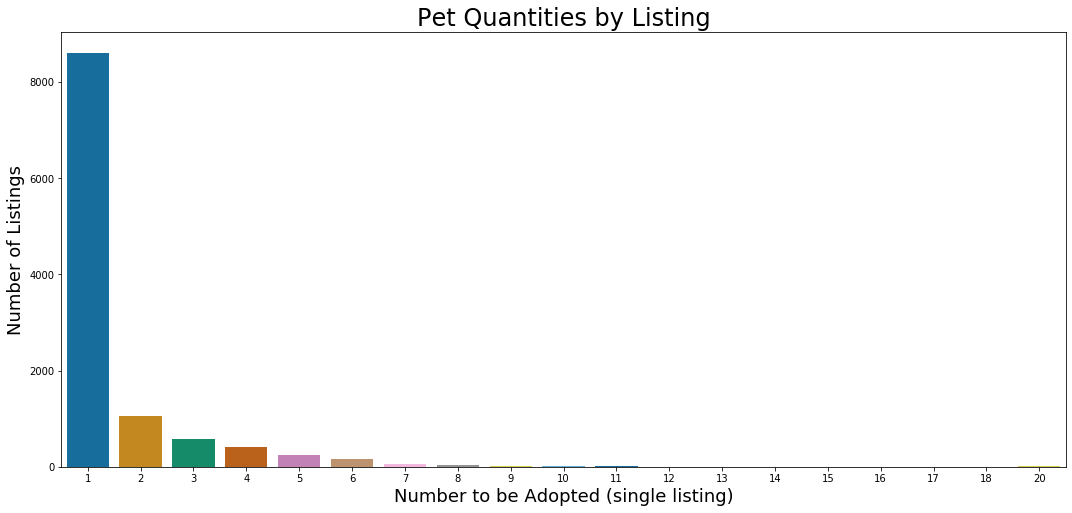

In [70]:
plt.figure(figsize = (18, 8))
sns.barplot(quant.index, quant, palette= 'colorblind' )

plt.title('Pet Quantities by Listing', size = 24)
plt.xlabel('Number to be Adopted (single listing)', size = 18)
plt.ylabel('Number of Listings', size = 18);


In [71]:
quant_m = pets[pets['quantity'] >6]
quant_m = quant_m['quantity'].value_counts()


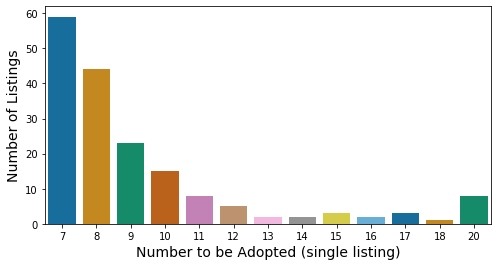

In [72]:
plt.figure(figsize = (8,4))
sns.barplot(quant_m.index, quant_m, palette = 'colorblind')
# plt.title('Listing Quantities for Groups Larger than Six', size = 14)
plt.xlabel('Number to be Adopted (single listing)', size = 14)
plt.ylabel('Number of Listings', size = 14);

Lots of large grouppings or litters.

They are lots of large groups/litters - Jerks
We'll use a cut off of groups of 3 this keeps it to individuals, pairs, etc. 

In [73]:
pets.drop(pets[pets['quantity'] > 3].index, inplace = True) 

Dropped listings with more than 3 pets. We are just looking at individual adoptions, pairs, etc

In [74]:
pets.shape

(10249, 24)

##### There are 14,993 rows and 24 features

In [75]:
pets.shape

(10249, 24)

- Immediately, 14989 (2 dogs) has an age of 60...probably an issue
- Quite a few actually see below

In [76]:
pets[pets['age'] > 35]

,type,name,age,breed1,breed2,gender,color1,color2,color3,maturitysize,...,health,quantity,fee,state,rescuerid,videoamt,description,petid,photoamt,adoptionspeed
1,2,Blu,48,266,0,2,5,7,0,2,...,1,1,0,41326,82a32b0880e7b35ae5133945a67e90a7,0,I will be moving to Australia soon and I am lo...,24fad6b0b,5.0,4
3,1,Summer Ooi,72,307,0,2,1,2,7,2,...,1,1,0,41327,fe7e8d2639220a64bd175caf3d3133f9,0,Very active female dog. Her name is Summer. Sh...,52363327c,4.0,4
17,1,Mummy,48,307,307,2,7,0,0,3,...,1,1,100,41332,f8ac73e4e6354fca89ef2574d0bc50f5,0,Mummy gave birth to 12 puppies in front of a h...,5d3ee6378,4.0,4
26,1,Dash,36,307,0,1,2,7,0,2,...,1,1,0,41401,ad05e60074673cfc038f8686cfbd776f,0,Dash is a 3-year old handsome dog. He is healt...,678d21531,5.0,4
29,1,Golden Retriever,36,109,0,1,3,0,0,2,...,1,1,0,41401,bd591197957f4994a9741d700ee01b11,0,no time to take care of him . And we charge RM...,ee0e059cb,5.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,1,Sabee,64,307,179,2,1,2,7,2,...,1,1,0,41401,24f239cdc75b79211d9343020396b521,0,Sabee is a very active doggie. She used to sta...,b2b9c5176,3.0,3
11182,1,Poby,48,307,0,2,5,7,0,2,...,1,1,100,41326,001e42763024f9d4abe31e79472b1827,0,Poby is a very easy n clean dog. She is easily...,f0c26af32,3.0,4
11187,1,Kopi,48,307,307,2,1,0,0,2,...,1,1,0,41401,8fb29f78b2a935b34a69fdd88bd365d4,0,*PETALING JAYA* 哈咯 我叫Kopi。这个名字是附近其中一个常喂我食物的人帮我...,560232264,4.0,4
11192,1,Bella And Blue,48,173,0,2,6,0,0,2,...,1,2,400,41326,7b12f4b1df96951a2cd34a22f5ba38f2,0,"2 female pitbulls, both are healthy, both are ...",9183ef863,5.0,2


- We will likely drop the name column for now.

In [77]:
pets.describe()

,type,age,breed1,breed2,gender,color1,color2,color3,maturitysize,furlength,vaccinated,dewormed,sterilized,health,quantity,fee,state,videoamt,photoamt,adoptionspeed
count,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000
mean,1.454191,11.098936,263.931701,72.932384,1.689043,2.276222,3.208215,1.685823,1.868670,1.475168,1.702215,1.527076,1.895112,1.038150,1.215533,22.405601,41346.459557,0.054444,3.759977,2.501512
std,0.497921,18.887640,61.323677,122.408760,0.620680,1.761076,2.791193,2.882766,0.550462,0.607166,0.674271,0.694206,0.572108,0.203905,0.529836,76.106974,32.694275,0.332007,3.315706,1.175481
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,2.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,2.000000
75%,2.000000,12.000000,307.000000,152.000000,2.000000,3.000000,6.000000,4.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,4.000000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1000.000000,41415.000000,8.000000,30.000000,4.000000


__Lets Explore Age__


In [78]:
pets['age'].value_counts()

2      2349
1      1383
3      1333
4       814
12      681
       ... 
135       1
238       1
102       1
86        1
255       1
Name: age, Length: 98, dtype: int64

Suspicioius, i wonder how many correspond to the big litteres? Looks like the bulk are pretty young 
  
Note that Age is in months


In [79]:
pets['breed1'].value_counts().value_counts().sum()

161

In [80]:
speed = pets.groupby(by = 'adoptionspeed').count()

In [81]:
pets['adoptionspeed'].value_counts(normalize = True)

4    0.273783
2    0.269295
3    0.218948
1    0.210947
0    0.027027
Name: adoptionspeed, dtype: float64

These are the percentages by Adoption Speed

''

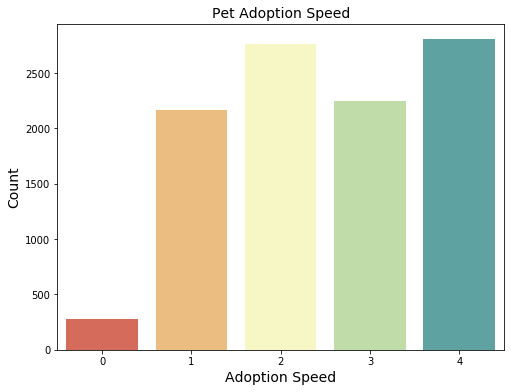

In [82]:
plt.figure(figsize = (8,6))
sns.barplot(speed.index, speed['type'] , palette = 'Spectral' )
plt.xlabel("Adoption Speed", size = 14)
plt.title("Pet Adoption Speed", size = 14)
plt.ylabel("Count", size = 14)

;

It appears that most pets stay in the shelter for more than 100 days or were not adopted
- 0 = Adopted the day it was listed
- 1 = Adopted in the first week
- 2 = Adopted after the first week, but in the first month
- 3 = Adopted between 31 and 90 days 
- 4 = No adoptions within 100 days (none between 90-100)

In [83]:
pets['type'].value_counts(normalize = True)

1    0.545809
2    0.454191
Name: type, dtype: float64

''

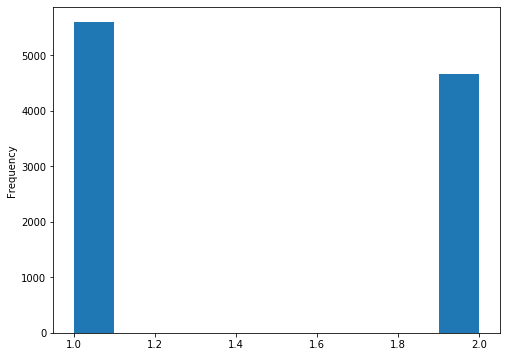

In [84]:
plt.figure(figsize = (8,6))
pets['type'].plot(kind = 'hist')

;

This measures the type, 1 is dog and 2 is cat - Pretty close, but more dogs than cats

In [85]:
pets['breed1'].value_counts()

307    3997
266    2467
265     845
299     222
264     205
       ... 
123       1
7         1
294       1
145       1
298       1
Name: breed1, Length: 161, dtype: int64

In [86]:
speed_corr = pets.corr()[['adoptionspeed']]
speed_corr = speed_corr.sort_values(by = 'adoptionspeed', ascending = False)

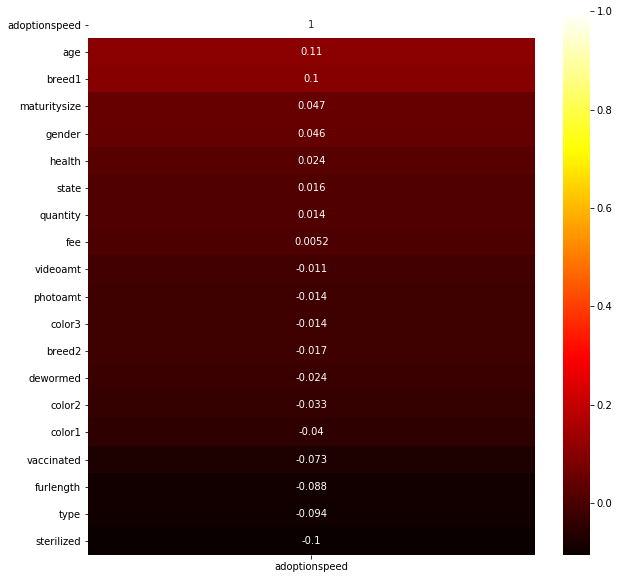

In [87]:
plt.figure(figsize = (10,10))
sns.heatmap(speed_corr, cmap = 'hot', annot= True);

Age, breed and size are unsurprisingly at the top of the list for correlation to adoption speed. Being sterilized and animal type also factor in and are negatively correlated 

In [88]:
pets['maturitysize'].value_counts() # they are numerical and ordinal based on size, so we'll keep it 'as is'

2    7036
1    2291
3     899
4      23
Name: maturitysize, dtype: int64

In [89]:
pets['fee'].describe()  # $1,000 adoption fee seems oddly high

count    10249.000000
mean        22.405601
std         76.106974
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1000.000000
Name: fee, dtype: float64

In [90]:
pets[pets['fee'] > 500]['adoptionspeed'].shape

(32,)

In [91]:
pets[(pets['fee'] > 500) & (pets['adoptionspeed']<3)]

,type,name,age,breed1,breed2,gender,color1,color2,color3,maturitysize,...,health,quantity,fee,state,rescuerid,videoamt,description,petid,photoamt,adoptionspeed
1280,2,0,2,285,264,2,4,0,0,2,...,1,1,750,41326,c004c5b717affa9822d9ec1ad3eb00fd,0,Ready for let go female cute Hyper aktif n hea...,d473d632a,3.0,2
1301,2,Jacky@bulat,2,285,0,1,1,7,0,2,...,1,1,600,41326,c004c5b717affa9822d9ec1ad3eb00fd,0,"berminat boleh call saya,kitten sngat sihat da...",08428917f,5.0,2
1572,2,Ricky,3,264,285,1,4,0,0,2,...,1,1,700,41326,c004c5b717affa9822d9ec1ad3eb00fd,0,Ready for new home our prince Red Tabby Really...,ff867121e,2.0,2
2080,2,Luna,2,285,0,2,3,0,0,2,...,1,1,700,41326,c004c5b717affa9822d9ec1ad3eb00fd,0,"For those are interested,pls call me female se...",09d9212f5,5.0,1
2087,1,Adpoted,24,205,0,2,1,2,7,1,...,1,1,1000,41401,67f04f1dc1f81ff09e134fb47a053b10,0,adpoted,aebf47483,2.0,0
2133,2,Ratu,2,285,264,2,1,4,7,2,...,1,1,550,41326,c004c5b717affa9822d9ec1ad3eb00fd,0,cute kitten now ready to go new home healty hy...,400cbe759,5.0,2
2431,1,"Chamomile Clary, C'mie",5,103,75,2,1,2,0,2,...,1,1,550,41401,8be1c3bc298f4193effbe89eaf52e68d,0,"********** NEW Update ********** C’mie, the lo...",6469a2a4a,5.0,2
4753,2,0,2,285,0,2,3,0,0,3,...,1,1,750,41326,c004c5b717affa9822d9ec1ad3eb00fd,0,Looking for serius buyer Only female 2 month p...,5b07e0e6a,5.0,2
4870,1,Oscar,24,189,0,1,1,2,0,3,...,1,1,800,41326,aa66486163b6cbc25ea62a34b11c9b91,0,Oscar was found in Ara Damansara recently. My ...,619d6fdf8,7.0,2
5089,1,Dobber Puppy,2,78,0,2,1,0,0,3,...,1,1,600,41326,370dba053360aeac8554b83bc5e73f7f,0,These are my close friend's puppies from the h...,8f128d3ed,3.0,2


I'm surprised that the pets with high fees (>500) tend to be adopted rather quickly. Probably higher fees charged for much sought after breeds and pets.

Of 33 pets with a fee > 500 (don't know the unit, remember this is Malaysia) 19 were adopted in the first week

In [92]:
pets['breed1'].value_counts()[:20]

307    3997
266    2467
265     845
299     222
264     205
292     183
285     158
141     145
205     141
179     126
218     118
109     108
103      73
254      72
20       70
189      65
243      64
195      58
213      54
247      53
Name: breed1, dtype: int64

In [93]:
breeds = {1 : 'Affenpinscher',
2 : 'Afghan Hound',
3 : 'Airedale Terrier',
4 : 'Akbash',
5 : 'Akita',
6 : 'Alaskan Malamute',
7 : 'American Bulldog',
8 : 'American Eskimo Dog',
9 : 'American Hairless Terrier',
10 : 'American Staffordshire Terrier',
11 : 'American Water Spaniel',
12 : 'Anatolian Shepherd',
13 : 'Appenzell Mountain Dog',
14 : 'Australian Cattle Dog/Blue Heeler',
15 : 'Australian Kelpie',
16 : 'Australian Shepherd',
17 : 'Australian Terrier',
18 : 'Basenji',
19 : 'Basset Hound',
20 : 'Beagle',
21 : 'Bearded Collie',
22 : 'Beauceron',
23 : 'Bedlington Terrier',
24 : 'Belgian Shepherd Dog Sheepdog',
25 : 'Belgian Shepherd Laekenois',
26 : 'Belgian Shepherd Malinois',
27 : 'Belgian Shepherd Tervuren',
28 : 'Bernese Mountain Dog',
29 : 'Bichon Frise',
30 : 'Black and Tan Coonhound',
31 : 'Black Labrador Retriever',
32 : 'Black Mouth Cur',
33 : 'Black Russian Terrier',
34 : 'Bloodhound',
35 : 'Blue Lacy',
36 : 'Bluetick Coonhound',
37 : 'Boerboel',
38 : 'Bolognese',
39 : 'Border Collie',
40 : 'Border Terrier',
41 : 'Borzoi',
42 : 'Boston Terrier',
43 : 'Bouvier des Flanders',
44 : 'Boxer',
45 : 'Boykin Spaniel',
46 : 'Briard',
47 : 'Brittany Spaniel',
48 : 'Brussels Griffon',
49 : 'Bull Terrier',
50 : 'Bullmastiff',
51 : 'Cairn Terrier',
52 : 'Canaan Dog',
53 : 'Cane Corso Mastiff',
54 : 'Carolina Dog',
55 : 'Catahoula Leopard Dog',
56 : 'Cattle Dog',
57 : 'Caucasian Sheepdog (Caucasian Ovtcharka)',
58 : 'Cavalier King Charles Spaniel',
59 : 'Chesapeake Bay Retriever',
60 : 'Chihuahua',
61 : 'Chinese Crested Dog',
62 : 'Chinese Foo Dog',
63 : 'Chinook',
64 : 'Chocolate Labrador Retriever',
65 : 'Chow Chow',
66 : 'Cirneco dellEtna',
67 : 'Clumber Spaniel',
68 : 'Cockapoo',
69 : 'Cocker Spaniel',
70 : 'Collie',
71 : 'Coonhound',
72 : 'Corgi',
73 : 'Coton de Tulear',
74 : 'Curly-Coated Retriever',
75 : 'Dachshund',
76 : 'Dalmatian',
77 : 'Dandi Dinmont Terrier',
78 : 'Doberman Pinscher',
79 : 'Dogo Argentino',
80 : 'Dogue de Bordeaux',
81 : 'Dutch Shepherd',
82 : 'English Bulldog',
83 : 'English Cocker Spaniel',
84 : 'English Coonhound',
85 : 'English Pointer',
86 : 'English Setter',
87 : 'English Shepherd',
88 : 'English Springer Spaniel',
89 : 'English Toy Spaniel',
90 : 'Entlebucher',
91 : 'Eskimo Dog',
92 : 'Feist',
93 : 'Field Spaniel',
94 : 'Fila Brasileiro',
95 : 'Finnish Lapphund',
96 : 'Finnish Spitz',
97 : 'Flat-coated Retriever',
98 : 'Fox Terrier',
99 : 'Foxhound',
100 : 'French Bulldog',
101 : 'Galgo Spanish Greyhound',
102 : 'German Pinscher',
103 : 'German Shepherd Dog',
104 : 'German Shorthaired Pointer',
105 : 'German Spitz',
106 : 'German Wirehaired Pointer',
107 : 'Giant Schnauzer',
108 : 'Glen of Imaal Terrier',
109 : 'Golden Retriever',
110 : 'Gordon Setter',
111 : 'Great Dane',
112 : 'Great Pyrenees',
113 : 'Greater Swiss Mountain Dog',
114 : 'Greyhound',
115 : 'Harrier',
116 : 'Havanese',
117 : 'Hound',
118 : 'Hovawart',
119 : 'Husky',
120 : 'Ibizan Hound',
121 : 'Illyrian Sheepdog',
122 : 'Irish Setter',
123 : 'Irish Terrier',
124 : 'Irish Water Spaniel',
125 : 'Irish Wolfhound',
126 : 'Italian Greyhound',
127 : 'Italian Spinone',
128 : 'Jack Russell Terrier',
129 : 'Jack Russell Terrier (Parson Russell Terrier)',
130 : 'Japanese Chin',
131 : 'Jindo',
132 : 'Kai Dog',
133 : 'Karelian Bear Dog',
134 : 'Keeshond',
135 : 'Kerry Blue Terrier',
136 : 'Kishu',
137 : 'Klee Kai',
138 : 'Komondor',
139 : 'Kuvasz',
140 : 'Kyi Leo',
141 : 'Labrador Retriever',
142 : 'Lakeland Terrier',
143 : 'Lancashire Heeler',
144 : 'Leonberger',
145 : 'Lhasa Apso',
146 : 'Lowchen',
147 : 'Maltese',
148 : 'Manchester Terrier',
149 : 'Maremma Sheepdog',
150 : 'Mastiff',
151 : 'McNab',
152 : 'Miniature Pinscher',
153 : 'Mountain Cur',
154 : 'Mountain Dog',
155 : 'Munsterlander',
156 : 'Neapolitan Mastiff',
157 : 'New Guinea Singing Dog',
158 : 'Newfoundland Dog',
159 : 'Norfolk Terrier',
160 : 'Norwegian Buhund',
161 : 'Norwegian Elkhound',
162 : 'Norwegian Lundehund',
163 : 'Norwich Terrier',
164 : 'Nova Scotia Duck-Tolling Retriever',
165 : 'Old English Sheepdog',
166 : 'Otterhound',
167 : 'Papillon',
168 : 'Patterdale Terrier (Fell Terrier)',
169 : 'Pekingese',
170 : 'Peruvian Inca Orchid',
171 : 'Petit Basset Griffon Vendeen',
172 : 'Pharaoh Hound',
173 : 'Pit Bull Terrier',
174 : 'Plott Hound',
175 : 'Podengo Portugueso',
176 : 'Pointer',
177 : 'Polish Lowland Sheepdog',
178 : 'Pomeranian',
179 : 'Poodle',
180 : 'Portuguese Water Dog',
181 : 'Presa Canario',
182 : 'Pug',
183 : 'Puli',
184 : 'Pumi',
185 : 'Rat Terrier',
186 : 'Redbone Coonhound',
187 : 'Retriever',
188 : 'Rhodesian Ridgeback',
189 : 'Rottweiler',
190 : 'Saint Bernard',
191 : 'Saluki',
192 : 'Samoyed',
193 : 'Sarplaninac',
194 : 'Schipperke',
195 : 'Schnauzer',
196 : 'Scottish Deerhound',
197 : 'Scottish Terrier Scottie',
198 : 'Sealyham Terrier',
199 : 'Setter',
200 : 'Shar Pei',
201 : 'Sheep Dog',
202 : 'Shepherd',
203 : 'Shetland Sheepdog Sheltie',
204 : 'Shiba Inu',
205 : 'Shih Tzu',
206 : 'Siberian Husky',
207 : 'Silky Terrier',
208 : 'Skye Terrier',
209 : 'Sloughi',
210 : 'Smooth Fox Terrier',
211 : 'South Russian Ovtcharka',
212 : 'Spaniel',
213 : 'Spitz',
214 : 'Staffordshire Bull Terrier',
215 : 'Standard Poodle',
216 : 'Sussex Spaniel',
217 : 'Swedish Vallhund',
218 : 'Terrier',
219 : 'Thai Ridgeback',
220 : 'Tibetan Mastiff',
221 : 'Tibetan Spaniel',
222 : 'Tibetan Terrier',
223 : 'Tosa Inu',
224 : 'Toy Fox Terrier',
225 : 'Treeing Walker Coonhound',
226 : 'Vizsla',
227 : 'Weimaraner',
228 : 'Welsh Corgi',
229 : 'Welsh Springer Spaniel',
230 : 'Welsh Terrier',
231 : 'West Highland White Terrier Westie',
232 : 'Wheaten Terrier',
233 : 'Whippet',
234 : 'White German Shepherd',
235 : 'Wire Fox Terrier',
236 : 'Wire-haired Pointing Griffon',
237 : 'Wirehaired Terrier',
238 : 'Xoloitzcuintle/Mexican Hairless',
239 : 'Yellow Labrador Retriever',
240 : 'Yorkshire Terrier Yorkie',
307 : 'Mixed Breed',
241 : 'Abyssinian',
242 : 'American Curl',
243 : 'American Shorthair',
244 : 'American Wirehair',
245 : 'Applehead Siamese',
246 : 'Balinese',
247 : 'Bengal',
248 : 'Birman',
249 : 'Bobtail',
250 : 'Bombay',
251 : 'British Shorthair',
252 : 'Burmese',
253 : 'Burmilla',
254 : 'Calico',
255 : 'Canadian Hairless',
256 : 'Chartreux',
257 : 'Chausie',
258 : 'Chinchilla',
259 : 'Cornish Rex',
260 : 'Cymric',
261 : 'Devon Rex',
262 : 'Dilute Calico',
263 : 'Dilute Tortoiseshell',
264 : 'Domestic Long Hair',
265 : 'Domestic Medium Hair',
266 : 'Domestic Short Hair',
267 : 'Egyptian Mau',
268 : 'Exotic Shorthair',
269 : 'Extra-Toes Cat (Hemingway Polydactyl)',
270 : 'Havana',
271 : 'Himalayan',
272 : 'Japanese Bobtail',
273 : 'Javanese',
274 : 'Korat',
275 : 'LaPerm',
276 : 'Maine Coon',
277 : 'Manx',
278 : 'Munchkin',
279 : 'Nebelung',
280 : 'Norwegian Forest Cat',
281 : 'Ocicat',
282 : 'Oriental Long Hair',
283 : 'Oriental Short Hair',
284 : 'Oriental Tabby',
285 : 'Persian',
286 : 'Pixie-Bob',
287 : 'Ragamuffin',
288 : 'Ragdoll',
289 : 'Russian Blue',
290 : 'Scottish Fold',
291 : 'Selkirk Rex',
292 : 'Siamese',
293 : 'Siberian',
294 : 'Silver',
295 : 'Singapura',
296 : 'Snowshoe',
297 : 'Somali',
298 : 'Sphynx (hairless cat)',
299 : 'Tabby',
300 : 'Tiger',
301 : 'Tonkinese',
302 : 'Torbie',
303 : 'Tortoiseshell',
304 : 'Turkish Angora',
305 : 'Turkish Van',
306 : 'Tuxedo'
}

In [94]:
pets['breed1'] = pets['breed1'].replace(breeds)
pets['breed1'][:3]

0    Domestic Short Hair
1    Domestic Short Hair
2            Mixed Breed
Name: breed1, dtype: object

In [95]:
pets['breed1'].value_counts()[:20]

Mixed Breed             3997
Domestic Short Hair     2467
Domestic Medium Hair     845
Tabby                    222
Domestic Long Hair       205
Siamese                  183
Persian                  158
Labrador Retriever       145
Shih Tzu                 141
Poodle                   126
Terrier                  118
Golden Retriever         108
German Shepherd Dog       73
Calico                    72
Beagle                    70
Rottweiler                65
American Shorthair        64
Schnauzer                 58
Spitz                     54
Bengal                    53
Name: breed1, dtype: int64

Mostly Mixed Breeds or general cat breads.
Most common dog is a Lab 

In [96]:
dogs = pets[pets['type'] ==1]
cats = pets[pets['type'] ==2]


In [97]:
dogs['breed1'].value_counts()[:10]

Mixed Breed            3994
Labrador Retriever      145
Shih Tzu                140
Poodle                  126
Terrier                 117
Golden Retriever        108
German Shepherd Dog      73
Beagle                   70
Rottweiler               65
Schnauzer                58
Name: breed1, dtype: int64

As expected mixed bread make up the majority with labs in second. I would have expected to find some kind of pitbull on this list, this is likely do to different preferences between the US and Malaysia.   

  
This makes me wonder if being labeled simply 'Mixed Breed' compared to having any breed at all. I'm not sure if this is possible with cats.

In [98]:
dogs['any_breed']=dogs['breed1'] != 'Mixed Breed'

C:\Users\weisj\anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [99]:
mixed = dogs[dogs['any_breed'] == True]
breed = dogs[dogs['any_breed'] == False]

We've now masked by being any breed (as opposed to Mixed Breed) makes a difference

In [100]:
print('Mixed Mean Speed: ',mixed['adoptionspeed'].mean())
print('Any Breed Mean Speed: ',breed['adoptionspeed'].mean())

Mixed Mean Speed:  2.28375
Any Breed Mean Speed:  2.730095142714071


Small difference but not likely significant. 

In [101]:
dogs.groupby('any_breed').describe() # mixed breed is false

type                                        age             ...  \
            count mean  std  min  25%  50%  75%  max   count       mean  ...   
any_breed                                                                ...   
False      3994.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  3994.0   8.030546  ...   
True       1600.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1600.0  28.258125  ...   

          photoamt       adoptionspeed                                     \
               75%   max         count      mean       std  min  25%  50%   
any_breed                                                                   
False          5.0  30.0        3994.0  2.730095  1.117339  0.0  2.0  3.0   
True           4.0  27.0        1600.0  2.283750  1.136461  0.0  1.0  2.0   

                     
           75%  max  
any_breed            
False      4.0  4.0  
True       3.0  4.0  

[2 rows x 152 columns]

looks like there is difference between the two. 2.73 mean for Mixed and 2.28 for Any  
Also all quartiles are lower except max

# breeds 

In [102]:
dogs.groupby('breed1')['adoptionspeed'].mean().sort_values()

breed1
Dutch Shepherd      1.0
Foxhound            1.0
Kuvasz              1.0
Lhasa Apso          1.0
Saint Bernard       1.0
                   ... 
Pointer             4.0
American Bulldog    4.0
Affenpinscher       4.0
Spaniel             4.0
0                   4.0
Name: adoptionspeed, Length: 106, dtype: float64

In [103]:
dogs['breed1'].value_counts()[:10]

Mixed Breed            3994
Labrador Retriever      145
Shih Tzu                140
Poodle                  126
Terrier                 117
Golden Retriever        108
German Shepherd Dog      73
Beagle                   70
Rottweiler               65
Schnauzer                58
Name: breed1, dtype: int64

In [104]:
cats['breed1'].value_counts()[:10]

Domestic Short Hair     2467
Domestic Medium Hair     845
Tabby                    222
Domestic Long Hair       205
Siamese                  183
Persian                  158
Calico                    72
American Shorthair        64
Bengal                    53
Oriental Short Hair       48
Name: breed1, dtype: int64

Generic Domestics by far the most

### Preprocessing

In [105]:
pets = pd.get_dummies(pets, columns = ['breed1','breed2','color1', 'color2', 'color3','type', 'gender'], drop_first = True)


In [106]:
pets.to_csv('../data/clean_pets.csv', index = False) # Clean and dummied data set

In [108]:
# Train-Test Split  - 7686x309 and 2563x309

X = pets.drop(columns = ['name', 'adoptionspeed', 'description', 'petid', 'rescuerid', 'state'])
y = pets['adoptionspeed']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = rdst)

print('X Train', X_train.shape)
print('X Test', X_test.shape)
print()
print('y Train', y_train.shape)
print('y Test', y_test.shape)

X Train (7686, 309)
X Test (2563, 309)

y Train (7686,)
y Test (2563,)


In [109]:
# Standard Scalar

ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test  = ss.transform(X_test)
print('Z Train', Z_train.shape)
print('Z Test', Z_test.shape)


Z Train (7686, 309)
Z Test (2563, 309)


The pre-processing has left us with three sets;   
- X_train/test => Features for training and predicting
- y_train/test => Target Value (Adoption Speed)   
- Z_train/test => X scaled, fitted to the X_train set


# Modeling

### Baseline

In [110]:
pets['adoptionspeed'].value_counts(normalize = True)

4    0.273783
2    0.269295
3    0.218948
1    0.210947
0    0.027027
Name: adoptionspeed, dtype: float64

Baseline of 27.37% - unfortunately this is pets that are never adopted.

###  K-Nearest Neighbors

In [145]:
knn = KNeighborsClassifier(n_neighbors = 5)    # Instantiate

In [146]:
# Fit model

knn.fit(Z_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [147]:
print("Train Score: ", knn.score(Z_train, y_train))
print('Test Score: ',  knn.score(Z_test, y_test))
print('Cross-Val: ',   cross_val_score(knn,Z_train, y_train).mean())

Train Score:  0.3201925578974759
Test Score:  0.1759656652360515
Cross-Val:  0.16055181551212272


### Decision Tree

In [114]:
# Does not need scaled values

dt = DecisionTreeClassifier(random_state = rdst)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=815, splitter='best')

In [115]:
print(f'Score on training set: {dt.score(X_train, y_train)}')
print(f'Score on testing set: {dt.score(X_test, y_test)}')
print('Cross-Val: ',   cross_val_score(dt,Z_train, y_train).mean())

Score on training set: 0.9798334634400209
Score on testing set: 0.32539992196644557
Cross-Val:  0.3298186137689062


At first pass it is a bit better on the test set, but massively overfit. Lets tune it

In [116]:
grid = GridSearchCV(DecisionTreeClassifier(),
                   param_grid = {'max_depth' : [2,3,4,5,6,7,8,9],
                                 'min_samples_split' : [5, 10, 15, 20, 25, 30],
                                 'min_samples_leaf' : [2, 3, 4, 5, 6, 7, 8, 9]},
                                cv = 5,
                                 verbose = 2) # to see it work
                                

In [117]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=5 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=15 ...........
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=15, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_

[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=4, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=4, min_samples_spl

[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=6, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=6, min_samples_spl

[CV]  max_depth=2, min_samples_leaf=7, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=8, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=8, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=8, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=8, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=2, min_samples_leaf=8, min_samples_split=5, total=   0.0s
[CV] max_depth=2, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=2, min_samples_leaf=8, min_samples_split=10, total=   0.0s
[CV] max_depth=2, min_samples_leaf=8, min_samples_spli

[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.0s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=2, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=2, min_samples_leaf=9, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=2, min_samples_spl

[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=4, min_samples_split=5, total=   0.0s
[CV] max_depth=3, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=4, min_samples_sp

[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=6, min_samples_split=5, total=   0.0s
[CV] max_depth=3, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=6, min_samples_sp

[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=8, min_samples_split=5 ............
[CV]  max_depth=3, min_samples_leaf=8, min_samples_split=5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=8, min_samples_sp

[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=3, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=3, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=5 ............
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=2, min_samples_sp

[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=4, min_samples_split=5 ............
[CV]  max_depth=4, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=4, min_samples_

[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=5, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=6, min_samples_split=5 ............
[CV]  max_depth=4, min_samples_leaf=6, min_samples_split=5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=6, min_samples_

[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=7, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=7, min_samples

[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples_split=30 ...........
[CV]  max_depth=4, min_samples_leaf=9, min_samples_split=30, total=   0.1s
[CV] max_depth=4, min_samples_leaf=9, min_samples

[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=30 ...........
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=30, total=   0.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples

[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=20, total=   0.0s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples

[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples

[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=20 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=20, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=25 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=25, total=   0.1s
[CV] max_depth=5, min_samples_leaf=9, min_samples

[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples

[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=5, min_samples

[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples_split=20 ...........
[CV]  max_depth=6, min_samples_leaf=7, min_samples_split=20, total=   0.1s
[CV] max_depth=6, min_samples_leaf=7, min_samples

[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_split=10 ...........
[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=10, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples_split=15 ...........
[CV]  max_depth=6, min_samples_leaf=9, min_samples_split=15, total=   0.1s
[CV] max_depth=6, min_samples_leaf=9, min_samples

[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples

[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=15 ...........
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=15, total=   0.1s
[CV] max_depth=7, min_samples_leaf=5, min_samples_

[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=10 ...........
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=10, total=   0.1s
[CV] max_depth=7, min_samples_leaf=7, min_samples_spl

[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=8, min_samples_split=30 ...........
[CV]  max_depth=7, min_samples_leaf=8, min_samples_split=30, total=   0.1s
[CV] max_depth=7, min_samples_leaf=9, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=9, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=9, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=9, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=9, min_samples_split=5 ............
[CV]  max_depth=7, min_samples_leaf=9, min_samples_split=5, total=   0.1s
[CV] max_depth=7, min_samples_leaf=9, min_samples_spli

[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=8, min_samples_leaf=3, min_samples_split=5 ............
[CV]  max_depth=8, min_samples_leaf=3, min_samples_split=5, total=   0.1s
[CV] max_depth=8, min_samples_leaf=3, min_samples_sp

[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=4, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=4, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=5, min_samples

[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples_split=30 ...........
[CV]  max_depth=8, min_samples_leaf=6, min_samples_split=30, total=   0.1s
[CV] max_depth=8, min_samples_leaf=6, min_samples

[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=20 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=20, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples_split=25 ...........
[CV]  max_depth=8, min_samples_leaf=8, min_samples_split=25, total=   0.1s
[CV] max_depth=8, min_samples_leaf=8, min_samples

[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=20 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=20 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=20 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=20 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=25 ...........
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=25, total=   0.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples

[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples_split=20 ...........
[CV]  max_depth=9, min_samples_leaf=4, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=4, min_samples

[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples_split=20 ...........
[CV]  max_depth=9, min_samples_leaf=6, min_samples_split=20, total=   0.1s
[CV] max_depth=9, min_samples_leaf=6, min_samples

[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=10 ...........
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=10, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples_split=15 ...........
[CV]  max_depth=9, min_samples_leaf=8, min_samples_split=15, total=   0.1s
[CV] max_depth=9, min_samples_leaf=8, min_samples

[Parallel(n_jobs=1)]: Done 1920 out of 1920 | elapsed:  2.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
              

In [118]:
dec_tree = grid.best_estimator_

In [119]:
dec_tree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [120]:
print('Train Score: ', grid.score(X_train, y_train))
print('Test Score: ', grid.score(X_test, y_test))
print('Cross Val: ', cross_val_score(dec_tree, X_train, y_train).mean())

Train Score:  0.4146500130106687
Test Score:  0.3765119001170503
Cross Val:  0.38862746657439


In [121]:
print(skm.classification_report(y_test, preds))

NameError: name 'preds' is not defined

Looks like it pulls kind of tight to the center, which means it isn't off by a ton. Scores show we are getting better, up from 32% to 37%

### Bootstrap and Bagging

In [122]:
# We will use the decision tree above as our starting point

# Bootstrap samples
def bootstrap(data, straps):
    output = []
    
    for strap in range (straps):
            bs = data.sample(n=data.shape[0], replace = True)
            output.append(bs)
    return output
      
# Adapted from Boom D. - NYC    

In [123]:
# Lets Generate Samples
np.random.seed(rdst)

predictions = pd.DataFrame(index = X_test.index)

# decision trees
for B in range (1,21):
    X_sample = X_train.sample(n = (X_train.shape[0]), replace = True)
    y_sample = y_train[X_sample.index]
    
    tree = DecisionTreeClassifier(random_state=rdst)  # Instantiate trees
    tree.fit(X_sample, y_sample)           # Fit
    predictions[f'tree{B}'] = tree.predict(X_test)
predictions.head()
    
                       
                       

,tree1,tree2,tree3,tree4,tree5,tree6,tree7,tree8,tree9,tree10,tree11,tree12,tree13,tree14,tree15,tree16,tree17,tree18,tree19,tree20
5389,2,1,2,3,1,3,4,3,2,1,1,2,2,2,3,4,1,1,2,2
3082,2,3,3,3,3,3,3,3,3,3,2,3,2,3,2,2,3,3,2,2
7731,2,2,1,3,2,2,2,3,2,2,4,2,2,2,4,2,2,2,2,2
8102,1,2,3,3,2,4,2,2,4,2,3,2,1,2,2,0,4,4,1,2
6947,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,3,2,2,2


In [124]:
bag = BaggingClassifier(dec_tree, n_estimators=300,  random_state= rdst)  # Instantiate
bag.fit(X_train, y_train)                                                # Fit 

print('Train: ', bag.score(X_train, y_train))
print('Test: ', bag.score(X_test, y_test))
print('Cross Val: ', cross_val_score(bag,X,y).mean())



Train:  0.4336455893832943
Test:  0.37690206788919234
Cross Val:  0.3947700841576498


Not much better than the decision tree.

### Random Forest

In [125]:
rf = RandomForestClassifier()
params = {
    'n_estimators' : [200,300, 400, 500],
    'max_features' : [None, 4, 5, 6, 7, 8],
    'max_depth' : [None, 6 ,10 ,15]
}

gs = GridSearchCV(rf, param_grid = params, cv = 5)
gs.fit(X_train, y_train)
print('Best Score: ', gs.best_score_)


Best Score:  0.404107185311091


In [126]:
gs.best_params_

{'max_depth': 15, 'max_features': None, 'n_estimators': 400}

In [127]:
print('RF Test Score: ', gs.score(X_test, y_test))
    

RF Test Score:  0.39172844323058914


In [128]:
preds = gs.predict(X_test)

''

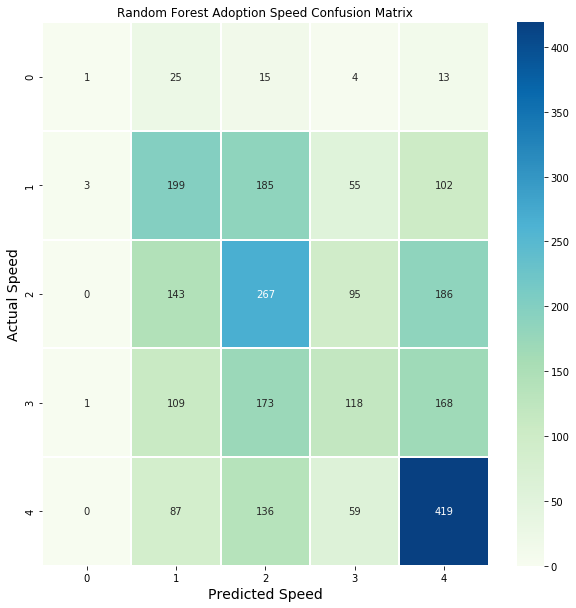

In [129]:
cm = confusion_matrix(y_test, preds)
plt.figure(figsize = (10,10))
sns.heatmap(cm, cmap = 'GnBu', fmt='g', annot = True, linewidth = 1 )
plt.title("Random Forest Adoption Speed Confusion Matrix")
plt.xlabel("Predicted Speed", size = 14)
plt.ylabel("Actual Speed", size = 14)
;

Out of 2,563 test observations, we were exactly right 1,013 times. This is an accuracy of 39.5%  
  
While this number doesn't seem that great, it is also valuble to be 'close'. For example, there are 186 pets that were predicted to be adopted within a month that were actually adopted in the first week. While this isn't an 'accurate' prediction, it is still instructive.


### Extra Trees

In [130]:
extree = ExtraTreesClassifier()
cross_val_score(extree, X_train, y_train, cv = 5).mean()

0.3494638111667722

In [131]:
extree = ExtraTreesClassifier()
params = {
    'n_estimators' : [10, 50, 100, 200,300],
    'max_features' : [None, 4, 5, 6, 7, 8],
    'max_depth' : [None, 6 ,10 ,15, 20]
}

gsext = GridSearchCV(extree, param_grid = params, cv = 5)
gsext.fit(X_train, y_train)
print('Best Score: ', gsext.best_score_)
gsext.best_params_

Best Score:  0.3858937707336924


{'max_depth': 10, 'max_features': None, 'n_estimators': 50}

In [132]:
print('Train: ', gsext.score(X_train, y_train))
print('Test: ', gsext.score(X_test, y_test))
print('Cross Val: ', cross_val_score(gsext,X,y).mean())

Train:  0.5539942753057507
Test:  0.37690206788919234
Cross Val:  0.38559806687378734


The Extra trees isn't as good as the Random Forest, Well stick with that for now.  


### Neural Network

In [133]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [134]:
Z_train.shape



(7686, 309)

In [135]:
model = Sequential()                        # Inatantiate
model.add(Dense(128,                        # Input Layer
               input_shape = (309,), 
               activation = 'relu'))
model.add(Dense(64, activation = 'relu'))   # First Hidden Layer
model.add(Dropout(.5))                      # First Dropout
model.add(Dense(32, activation = 'relu'))   # Second Hidden Layer
model.add(Dropout(.5))
model.add(Dense(5, activation = 'softmax')) # Output Layer

In [136]:
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [137]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta=0, patience=5, verbose =1, mode='auto')
history_es = model.fit(Z_train, y_train, validation_data = (Z_test, y_test),epochs = 5000, batch_size = 512, callbacks=[early_stop])

Train on 7686 samples, validate on 2563 samples
Epoch 1/5000
7686/7686 [==============================] - 1s 192us/step - loss: 1.8263 - accuracy: 0.2006 - val_loss: 1.5834 - val_accuracy: 0.2591
Epoch 2/5000
7686/7686 [==============================] - 1s 185us/step - loss: 1.6529 - accuracy: 0.2368 - val_loss: 1.5691 - val_accuracy: 0.2688
Epoch 3/5000
7686/7686 [==============================] - 1s 176us/step - loss: 1.6147 - accuracy: 0.2460 - val_loss: 1.5556 - val_accuracy: 0.2708
Epoch 4/5000
7686/7686 [==============================] - 1s 181us/step - loss: 1.5817 - accuracy: 0.2649 - val_loss: 1.5432 - val_accuracy: 0.2653
Epoch 5/5000
7686/7686 [==============================] - 1s 150us/step - loss: 1.5558 - accuracy: 0.2663 - val_loss: 1.5262 - val_accuracy: 0.2844
Epoch 6/5000
7686/7686 [==============================] - 1s 192us/step - loss: 1.5435 - accuracy: 0.2693 - val_loss: 1.5126 - val_accuracy: 0.29578 - accuracy: 0.
Epoch 7/5000
7686/7686 [========================

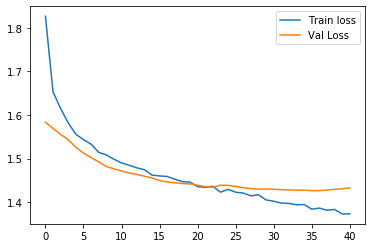

In [138]:
plt.plot(history_es.history['loss'], label='Train loss')
plt.plot(history_es.history['val_loss'], label='Val Loss')
plt.legend();

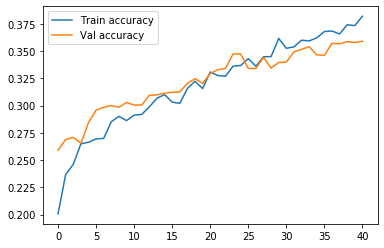

In [139]:
plt.plot(history_es.history['accuracy'], label='Train accuracy')
plt.plot(history_es.history['val_accuracy'], label='Val accuracy')
plt.legend();

### GridSearch

In [140]:
# def grid_search(layer_one_neurons = 64, layer_two_neurons = 32):
#     model_gs = Sequential()                        # Instantiate
#     model.add(Dense(128,                           # Input Layer
#                    input_shape = (309,), 
#                    activation = 'relu'))
#     model.add(Dense(64, activation = 'relu'))      # First Hidden Layer
#     model.add(Dropout(.5))                         # First Dropout
#     model.add(Dense(32, activation = 'relu'))      # Second Hidden Layer
#     model.add(Dropout(.5))                         # Second Dropout
#     model.add(Dense(5, activation = 'softmax'))    # Output Layer
#     return model

# nn = KerasClassifier(build_fn = grid_search, batch_size = 512, verbose = 1)

# params = {
#     'epochs' : [1_000],
#     'layer_one_neurons' : [32],
#     'layer_one_neurons' : [16]
# }

# gs = GridSearchCV(nn, param_grid = params, cv = 5)
# gs.fit(Z_train, y_train)
# print(gs.best_score_)
# gs.best_params_

## Model Selection

In [148]:
print('Train: ', knn.score(Z_train, y_train))
print('Test: ', knn.score(Z_test, y_test))
print('Cross Val: ', cross_val_score(knn,Z,y).mean())

Train:  0.3201925578974759
Test:  0.1759656652360515


NameError: name 'Z' is not defined

In [ ]:
print('Train: ', grid.score(X_train, y_train))
print('Test: ', grid.score(X_test, y_test))
print('Cross Val: ', cross_val_score(grid,X,y).mean())

In [ ]:
print('Train: ', bag.score(X_train, y_train))
print('Test: ', bag.score(X_test, y_test))
print('Cross Val: ', cross_val_score(bag,X,y).mean())

In [ ]:
print('Train: ', gs.score(X_train, y_train))
print('Test: ', gs.score(X_test, y_test))
print('Cross Val: ', cross_val_score(gs,X,y).mean())

In [ ]:
print('Train: ', gsext.score(X_train, y_train))
print('Test: ', gsext.score(X_test, y_test))
print('Cross Val: ', cross_val_score(gsext,X,y).mean())

In [ ]:
print('Train: ', history_es.score(X_train, y_train))
print('Test: ', history_es.score(X_test, y_test))
print('Cross Val: ', cross_val_score(history_es,X,y).mean())

## Model Evaluation

In [ ]:
gs.best_params_

In [ ]:
print('RF Test Score: ', gs.score(X_test, y_test))
    

In [ ]:
rf = gs.best_estimator_

In [ ]:
preds = rf.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, preds)
plt.figure(figsize = (10,10))
sns.heatmap(cm, cmap = 'GnBu', fmt='g', annot = True, linewidth = 1 )
plt.title("Random Forest Adoption Speed Confusion Matrix")
plt.xlabel("Predicted Adoption Speed", size = 14)
plt.ylabel("Actual Adoption Speed", size = 14)
;

In [ ]:
classification_report(y_test, preds, output_dict = True)

In [ ]:
feat_importance = list(zip(X_train.columns, rf.feature_importances_))
importance = feat_importance.sort(reverse = True)

In [ ]:
imp_all = pd.DataFrame(feat_importance)
imp_all = imp_all.sort_values(by = [1], ascending = True)
imp = imp_all.tail(15)
imp



In [ ]:
plt.figure(figsize = (14,14), facecolor = ('#3f3f3f'))

plt.bar(imp[0],imp[1], 
         color = ['#597d35','#3cec97','#b2d3c2', '#3a5311', '#234f1e', '#729c69', '#98bf64','#74b62e', '#98edc3','#3bb143','#354a21','#466d1e', '#b0fc38', '#03ac13', '#028910'],
         tick_label = ['Primary Color: Brown', 'Secondary Color: White', 'Secondary Breed: Mixed', 'Type','Gender', 'Quantity', 'Dewormed', 'Fur Length', 'Vaccinated', 'Maturity Size', 'Fee', 'Sterilized', 'Main Breed: Mixed', '# of Photos', 'Age'])
ax.set_facecolor('#3f3f3f')        
plt.xticks(rotation=45, ha='right', color = 'white', size = 18 ) 
plt.yticks(color='white', size = 18)
plt.title("Feature Importance (MDI)", size = 24, color = 'white')
fig.tight_layout()
;

This is the feature importantce. It show's what features have the most impact on predicting the target variable. Because this is based on the training data, it is vulnerable to overfitting and giving additional 'credit' to those overfit features. MDI is the Mean Decrease in Impurity.

In [ ]:
res = permutation_importance(rf, X_test, y_test, n_repeats = 10, 
                                random_state = rdst)

In [ ]:
results = list(zip(X_test.columns, res))
result = results.sort(reverse = True)

In [ ]:
sorted_idx = res.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(limit,
           vert=False, labels=lim_lab)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [ ]:
interp = local_interpretation
print(local_interpretation)

In [ ]:
interp.head(10)

In [ ]:
interp.tail(10)

# Conclusions and Recommendations

Most of our models performed well in the range of 35%+ accuracy. We ultimately selected the Random Forest model as it produced the best results, which were about 11.5 percentage points above the baseline accuracy.  

We are able to conclude from our work that there are key factors that affect the speed at which dogs and cats are adopted. Those factors include age, spay/neuter status, breed and the number of photos available. Being able to more accurately predict the speed at which pets are adopted will allow us to better allocate resources to get the most pets into forever homes. 

Other Recommendations:
Include multiple pictures of the pet

Even if the breed is unknown or mixed, it is best to take a guess and include a breed rather than ‘mixed’

Spay/Neutering the pet helps in adoption, and helps keep the population down for the future

Focusing on pets identified as being more difficult to home may increase their likelihood of finding a forever home. 

## Pickling

In [ ]:
# pip install treeinterpreter


In [ ]:
best_rf = 'finalized_rf.sav'
pickle.dump(rf, open(best_rf, 'wb'))

We also need the scaler, so we will pickle that below

In [ ]:
sscaler = 'finalized_ss.sav'
pickle.dump(ss, open(sscaler, 'wb'))

## References

References:  
https://www.linkedin.com/pulse/kaggle-competition-multi-class-classification-image-alexandra/  
https://www.kaggle.com/c/petfinder-adoption-prediction/data    
https://stackoverflow.com/questions/53886370/multi-class-multi-label-confusion-matrix-with-sklearn
https://towardsdatascience.com/interpreting-random-forest-and-other-black-box-models-like-xgboost-80f9cc4a3c38  
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/  
https://stackoverflow.com/questions/44266677/machine-learning-test-set-with-fewer-features-than-the-train-set